In [5]:
libraries = c("dplyr", "tidyverse", "magrittr")
for(x in libraries) {library(x,character.only=TRUE,warn.conflicts=FALSE,quietly=TRUE)}
theme_set(theme_bw())

── Attaching packages ───────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   0.3.5
✔ tibble  3.1.8     ✔ stringr 1.4.1
✔ tidyr   1.2.1     ✔ forcats 0.5.2
✔ readr   2.1.3     
── Conflicts ──────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [6]:
#### setting
start_date <- as.Date("2022-04-17") ## symptom onset date of the initial case in the UK
start_date <- as.Date("2022-04-18") ## symptom onset date of the initial case in the UK + 1 (for the convolution)

In [7]:
#### data with depletion effect
read.csv("../data/input_WHO_backproj_conv.csv") -> df_input
df_input$date <- as.Date(df_input$date)
df_input$date_import <- as.Date(df_input$date_import)
censor_import <- max(df_input$date) ## for countries without any importation

## excluding the endemic countries (along with the UK)
df_input %<>% rename(censor=censoring, country=location) %>%
mutate(date_imp=case_when(censor==1~censor_import, censor==0~date_import)) %>%
filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                        "Congo","Congo, Democratic Republic of the","Ghana","Palestine, State of",
                        "United Kingdom")))

df_input %>% dplyr::select(date, country, F_i, date_imp, censor) %>% 
filter(date >= start_date) %>% arrange(date, country) -> df_input_all

## regional specific data
data_list <- list()
df_input %>% filter(region == c("Europe")) %>% dplyr::select(date, country, F_i, date_imp, censor) %>% 
filter(date >= start_date) %>% arrange(date, country) -> data_list[[1]]

df_input %>% filter(region == c("Africa")) %>% dplyr::select(date, country, F_i, date_imp, censor) %>% 
filter(date >= start_date) %>% arrange(date, country) -> data_list[[2]]

df_input %>% filter(region == c("Americas")) %>% dplyr::select(date, country, F_i, date_imp, censor) %>% 
filter(date >= start_date) %>% arrange(date, country) -> data_list[[3]]

df_input %>% filter(region == c("Asia")) %>% filter(!sub_region %in% c("Central Asia", "Western Asia")) %>% 
dplyr::select(date, country, F_i, date_imp, censor) %>% 
filter(date >= start_date) %>% arrange(date, country) -> data_list[[4]]

df_input %>% filter(sub_region %in% c("Central Asia", "Western Asia")) %>% 
dplyr::select(date, country, F_i, date_imp, censor) %>% 
filter(date >= start_date) %>% arrange(date, country) -> data_list[[5]]

df_input %>% filter(region == c("Oceania")) %>% dplyr::select(date, country, F_i, date_imp, censor) %>% 
filter(date >= start_date) %>% arrange(date, country) -> data_list[[6]]

In [8]:
#### data without depletion effect
read.csv("../data/input_WHO_backproj_counter_conv.csv") -> df_input_counter
df_input_counter$date <- as.Date(df_input_counter$date)
df_input_counter$date_import <- as.Date(df_input_counter$date_import)

read.csv("../data/input_WHO_backproj_counter_degree_conv.csv") -> df_input_counter2
df_input_counter2$date <- as.Date(df_input_counter2$date)
df_input_counter2$date_import <- as.Date(df_input_counter2$date_import)

## excluding the endemic countries (along with the UK)
df_input_counter %<>% rename(censor=censoring, country=location) %>%
mutate(date_imp=case_when(censor==1~censor_import, censor==0~date_import)) %>% 
filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                         "Congo","Congo, Democratic Republic of the","Ghana","Palestine, State of",
                         "United Kingdom")))

df_input_counter2 %<>% rename(censor=censoring, country=location) %>%
mutate(date_imp=case_when(censor==1~censor_import, censor==0~date_import)) %>% 
filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                         "Congo","Congo, Democratic Republic of the","Ghana","Palestine, State of",
                         "United Kingdom")))

df_input_counter %>% dplyr::select(date, country, F_i, date_imp, censor) %>% 
filter(date >= start_date) %>% arrange(date, country) -> df_input_counter_all

## regional specific data
data_list_counter <- list()
df_input_counter %>% filter(region == c("Europe")) %>% dplyr::select(date, country, F_i, date_imp, censor) %>% 
filter(date >= start_date) %>% arrange(date, country) -> data_list_counter[[1]]

df_input_counter %>% filter(region == c("Africa")) %>% dplyr::select(date, country, F_i, date_imp, censor) %>% 
filter(date >= start_date) %>% arrange(date, country) -> data_list_counter[[2]]

df_input_counter %>% filter(region == c("Americas")) %>% dplyr::select(date, country, F_i, date_imp, censor) %>% 
filter(date >= start_date) %>% arrange(date, country) -> data_list_counter[[3]]

df_input_counter %>% filter(region == c("Asia")) %>% filter(!sub_region %in% c("Central Asia", "Western Asia")) %>% 
dplyr::select(date, country, F_i, date_imp, censor) %>% 
filter(date >= start_date) %>% arrange(date, country) -> data_list_counter[[4]]

df_input_counter %>% filter(sub_region %in% c("Central Asia", "Western Asia")) %>% 
dplyr::select(date, country, F_i, date_imp, censor) %>% 
filter(date >= start_date) %>% arrange(date, country) -> data_list_counter[[5]]

df_input_counter %>% filter(region == c("Oceania")) %>% dplyr::select(date, country, F_i, date_imp, censor) %>% 
filter(date >= start_date) %>% arrange(date, country) -> data_list_counter[[6]]

In [9]:
#### likelihood without random effect
LogL_i <- function(data, country_i){
    data_i <- data %>% filter(country==country_i)
    date_start_i <- data_i[1,1]
    date_import_i <- data_i[length(data_i[,1]), 4]
    surv_days_i <- as.numeric(date_import_i - date_start_i)+1
    F_i_vec <- data_i$F_i
    cens_i <- data_i[1,5] 
    
    function(alpha){
        return(
            (1-cens_i) * (log(alpha * F_i_vec[surv_days_i]) + (-sum(alpha * F_i_vec[1:surv_days_i]))) + 
            cens_i * (-sum(alpha * F_i_vec[1:surv_days_i])) 
        )
    }
}

LogL_full <- function(data, country_list){
  function(alpha){
      return(sum(sapply(country_list, FUN = function(x){LogL_i(data=data, country_i = x)(alpha=alpha)})))
  }
}

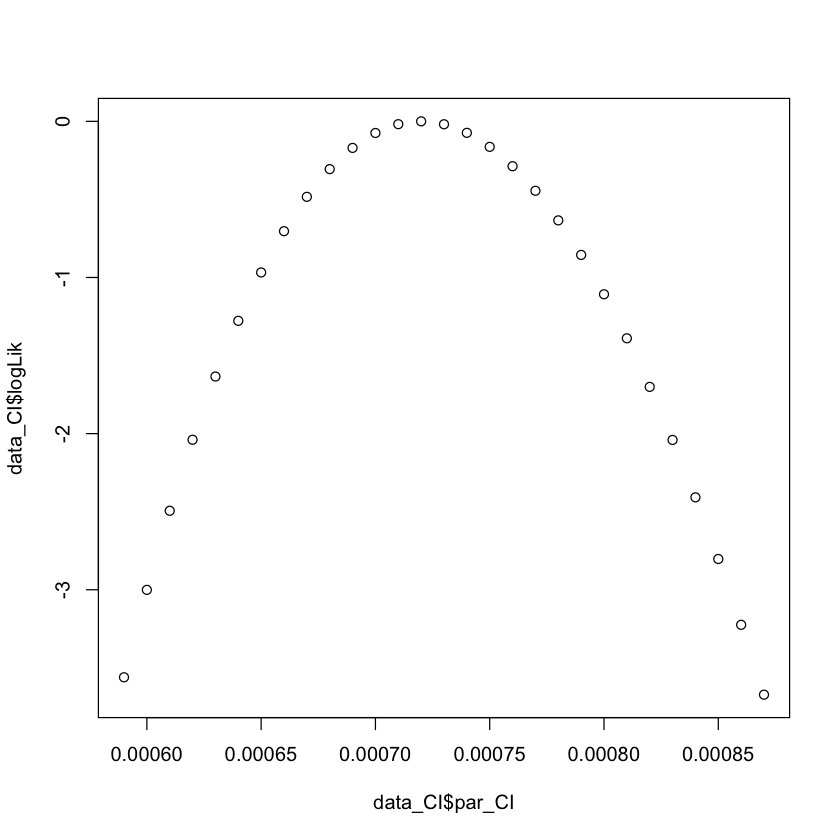

In [10]:
#### MLE for the model with depletion effect
## with global scaling factor
options(warn=-1)
optim(fn=LogL_full(data=df_input_all, country_list=(unique(df_input_all$country))), 
      par=c(0.001), method="Brent", lower=(0), upper=(1000), 
      control = list(fnscale = -1, maxit=1000000)) -> est_all

ci_pro <- matrix(NA, ncol=2, nrow=1); colnames(ci_pro) <- c("lower","upper")
CI <- function(par_CI){
    return(2*(LogL_full(data=df_input_all, country_list=(unique(df_input_all$country)))(par_CI)-est_all$value))}
par_CI <- seq(0.00001, 0.0015, by = 0.00001)
logLik <- sapply(par_CI, FUN = CI)
as.data.frame(par_CI) -> par_CI; as.data.frame(logLik) -> logLik
cbind(par_CI, logLik) -> data_CI
data_CI$logLik[data_CI$logLik<(max(data_CI$logLik)-3.84)] <- NA
data_CI %<>% na.omit()
min(data_CI$par_CI) -> ci_pro[1,1]; max(data_CI$par_CI) -> ci_pro[1,2]
saveRDS(ci_pro, "est_all_ci_conv.rds")

plot(data_CI$par_CI, data_CI$logLik)

In [11]:
## with regional specific scaling factors (separate MLE by region)
par_list <- list(); value_list <- list(); CI_list <- list(); llk_list <- list();
for(i in 1:length(data_list)){
    optim(fn=LogL_full(data=data_list[[i]], country_list=(unique(data_list[[i]]$country))), 
          par=c(0.001), method="Brent", lower=(0), upper=(1000), control = list(fnscale = -1, maxit=1000000)) -> est
    est$par -> par_list[[i]]; est$value -> value_list[[i]]
    
    ci_pro <- matrix(NA, ncol=2, nrow=1); colnames(ci_pro) <- c("lower","upper")
    CI <- function(par_CI){return(2*(LogL_full(data=data_list[[i]], 
                           country_list=(unique(data_list[[i]]$country)))(par_CI)-value_list[[i]]))}
    par_CI <- seq(0.00001, 0.005, by = 0.00001)
    logLik <- sapply(par_CI, FUN = CI)
    as.data.frame(par_CI) -> par_CI; as.data.frame(logLik) -> logLik
    cbind(par_CI, logLik) -> data_CI
    data_CI$logLik[data_CI$logLik<(max(data_CI$logLik)-3.84)] <- NA
    data_CI %<>% na.omit()
    min(data_CI$par_CI) -> ci_pro[1,1]; max(data_CI$par_CI) -> ci_pro[1,2]
    ci_pro -> CI_list[[i]]
    data_CI -> llk_list[[i]]
}
saveRDS(CI_list, "est_region_ci_conv.rds")
saveRDS(llk_list, "est_region_ci_data_conv.rds")

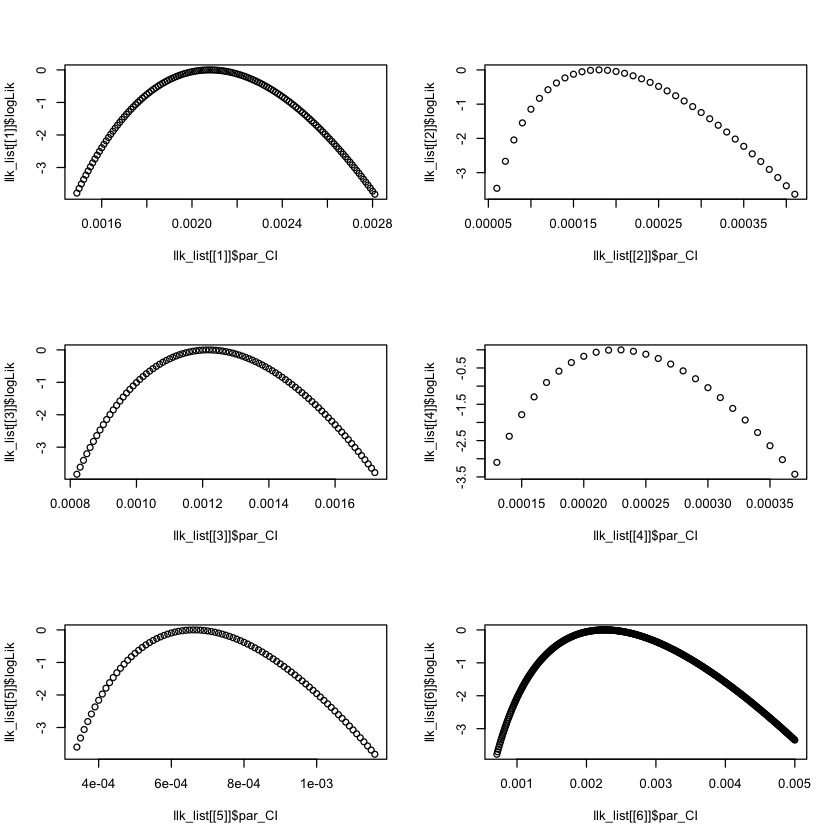

In [12]:
par(mfrow=c(3,2))

plot(llk_list[[1]]$par_CI, llk_list[[1]]$logLik)
plot(llk_list[[2]]$par_CI, llk_list[[2]]$logLik)
plot(llk_list[[3]]$par_CI, llk_list[[3]]$logLik)
plot(llk_list[[4]]$par_CI, llk_list[[4]]$logLik)
plot(llk_list[[5]]$par_CI, llk_list[[5]]$logLik)
plot(llk_list[[6]]$par_CI, llk_list[[6]]$logLik)

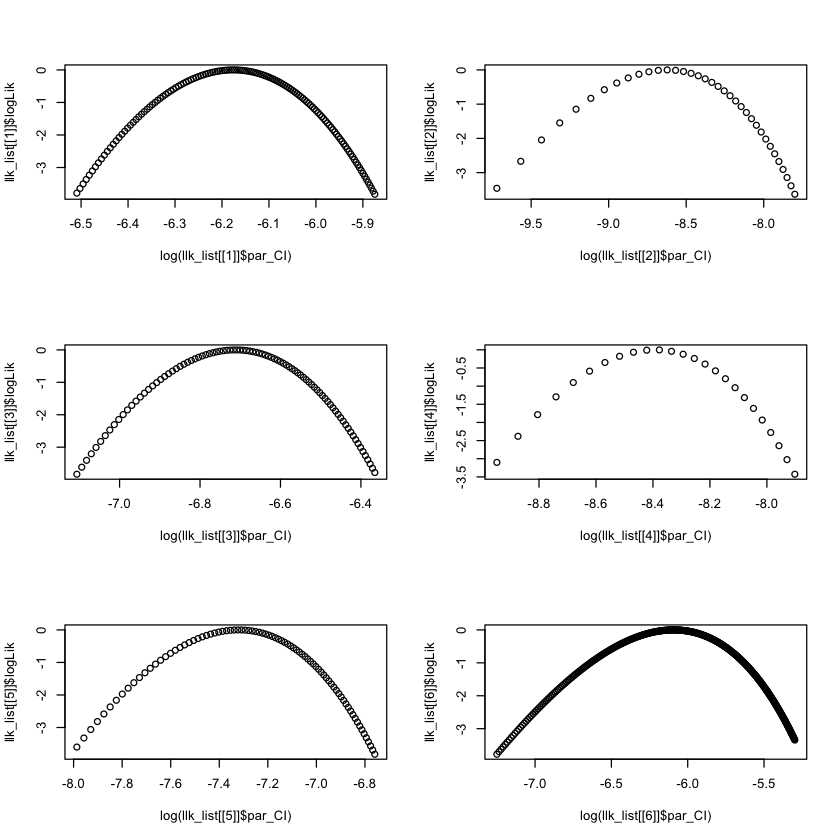

In [13]:
par(mfrow=c(3,2))

plot(log(llk_list[[1]]$par_CI), llk_list[[1]]$logLik)
plot(log(llk_list[[2]]$par_CI), llk_list[[2]]$logLik)
plot(log(llk_list[[3]]$par_CI), llk_list[[3]]$logLik)
plot(log(llk_list[[4]]$par_CI), llk_list[[4]]$logLik)
plot(log(llk_list[[5]]$par_CI), llk_list[[5]]$logLik)
plot(log(llk_list[[6]]$par_CI), llk_list[[6]]$logLik)

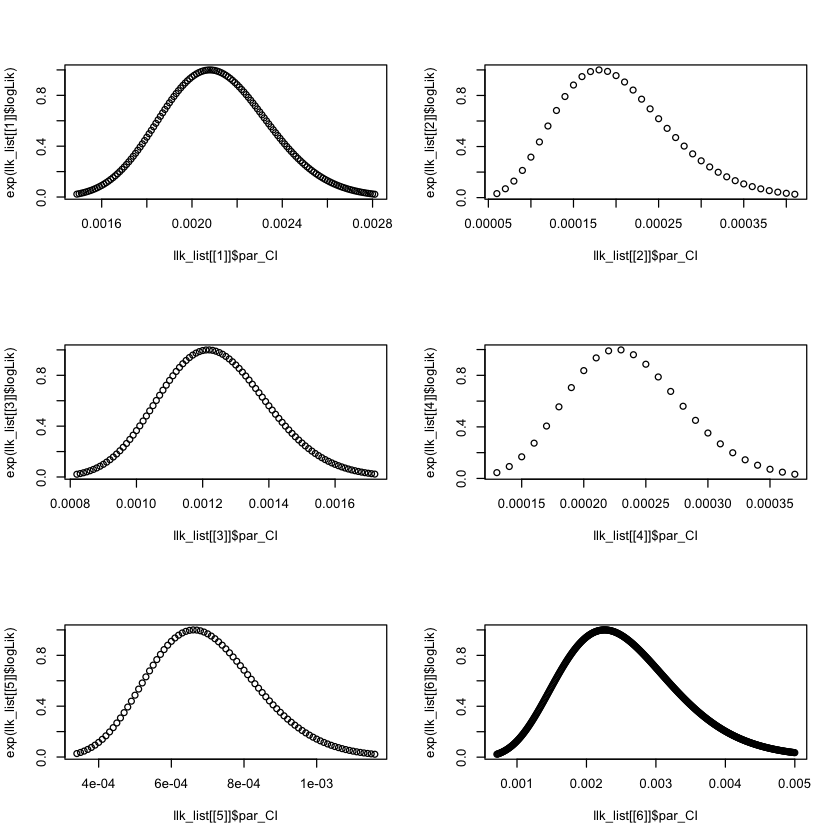

In [14]:
par(mfrow=c(3,2))

plot(llk_list[[1]]$par_CI, exp(llk_list[[1]]$logLik))
plot(llk_list[[2]]$par_CI, exp(llk_list[[2]]$logLik))
plot(llk_list[[3]]$par_CI, exp(llk_list[[3]]$logLik))
plot(llk_list[[4]]$par_CI, exp(llk_list[[4]]$logLik))
plot(llk_list[[5]]$par_CI, exp(llk_list[[5]]$logLik))
plot(llk_list[[6]]$par_CI, exp(llk_list[[6]]$logLik))

In [15]:
# #### MLE for the model with depletion effect
# ## with global scaling factor
# options(warn=-1)
# optim(fn=LogL_full(data=df_input_all, country_list=(unique(df_input_all$country))), 
#       par=c(0.001), method="Brent", lower=(0), upper=(1000), 
#       control = list(fnscale = -1, maxit=1000000)) -> est_all

# ci_pro <- matrix(NA, ncol=2, nrow=1); colnames(ci_pro) <- c("lower","upper")
# CI <- function(par_CI){
#     return(2*(LogL_full(data=df_input_all, country_list=(unique(df_input_all$country)))(par_CI)-est_all$value))}
# par_CI <- seq(0.00001, 0.0015, by = 0.00001)
# logLik <- sapply(par_CI, FUN = CI)
# as.data.frame(par_CI) -> par_CI; as.data.frame(logLik) -> logLik
# cbind(par_CI, logLik) -> data_CI
# data_CI$logLik[data_CI$logLik<(max(data_CI$logLik)-3.84)] <- NA
# data_CI %<>% na.omit()
# min(data_CI$par_CI) -> ci_pro[1,1]; max(data_CI$par_CI) -> ci_pro[1,2]
# saveRDS(ci_pro, "est_all_ci.rds")


# ## with regional specific scaling factors (separate MLE by region)
# par_list <- list(); value_list <- list(); CI_list <- list(); llk_list <- list();
# for(i in 1:length(data_list)){
#     optim(fn=LogL_full(data=data_list[[i]], country_list=(unique(data_list[[i]]$country))), 
#           par=c(0.001), method="Brent", lower=(0), upper=(1000), control = list(fnscale = -1, maxit=1000000)) -> est
#     est$par -> par_list[[i]]; est$value -> value_list[[i]]
    
    
#     ci_pro <- matrix(NA, ncol=2, nrow=1); colnames(ci_pro) <- c("lower","upper")
#     CI <- function(par_CI){return(2*(LogL_full(data=data_list[[i]], 
#                            country_list=(unique(data_list[[i]]$country)))(par_CI)-value_list[[i]]))}
#     par_CI <- seq(0.00001, 0.005, by = 0.00001)
#     logLik <- sapply(par_CI, FUN = CI)
#     as.data.frame(par_CI) -> par_CI; as.data.frame(logLik) -> logLik
#     cbind(par_CI, logLik) -> data_CI
#     data_CI$logLik[data_CI$logLik<(max(data_CI$logLik)-3.84)] <- NA
#     data_CI %<>% na.omit()
#     min(data_CI$par_CI) -> ci_pro[1,1]; max(data_CI$par_CI) -> ci_pro[1,2]
#     ci_pro -> CI_list[[i]]
#     data_CI -> llk_list[[i]]
# }
# saveRDS(CI_list, "est_region_ci_conv.rds")


# #### MLE for the model without depletion effect
# ## with global scaling factor
# optim(fn=LogL_full(data=df_input_counter_all, country_list=(unique(df_input_counter_all$country))), 
#       par=c(0.001), method="Brent", lower=(0), upper=(1000), 
#       control = list(fnscale = -1, maxit=1000000)) -> est_all_counter

# ci_pro <- matrix(NA, ncol=2, nrow=1); colnames(ci_pro) <- c("lower","upper")
# CI <- function(par_CI){return(2*(LogL_full(data=df_input_counter_all, 
#                        country_list=(unique(df_input_counter_all$country)))(par_CI)-est_all_counter$value))}
# par_CI <- seq(0.00001, 0.1, by = 0.00001)
# logLik <- sapply(par_CI, FUN = CI)
# as.data.frame(par_CI) -> par_CI; as.data.frame(logLik) -> logLik
# cbind(par_CI, logLik) -> data_CI
# data_CI$logLik[data_CI$logLik<(max(data_CI$logLik)-3.84)] <- NA
# data_CI %<>% na.omit()
# min(data_CI$par_CI) -> ci_pro[1,1]; max(data_CI$par_CI) -> ci_pro[1,2]
# saveRDS(ci_pro, "est_all_counter_ci_conv.rds")


# ## with regional specific scaling factors (separate MLE by region)
# par_list_counter <- list(); value_list_counter <- list(); CI_list_counter <- list()
# for(i in 1:length(data_list_counter)){
#     optim(fn=LogL_full(data=data_list_counter[[i]], country_list=(unique(data_list_counter[[i]]$country))), 
#           par=c(0.001), method="Brent", lower=(0), upper=(1000), 
#           control = list(fnscale = -1, maxit=1000000)) -> est
#     est$par -> par_list_counter[[i]]; est$value -> value_list_counter[[i]]
    
#     ci_pro <- matrix(NA, ncol=2, nrow=1); colnames(ci_pro) <- c("lower","upper")
#     CI <- function(par_CI){return(2*(LogL_full(data=data_list_counter[[i]], 
#                            country_list=(unique(data_list_counter[[i]]$country)))(par_CI)-value_list_counter[[i]]))}
#     par_CI <- seq(0.0001, 0.1, by = 0.00001)
#     logLik <- sapply(par_CI, FUN = CI)
#     as.data.frame(par_CI) -> par_CI; as.data.frame(logLik) -> logLik
#     cbind(par_CI, logLik) -> data_CI
#     data_CI$logLik[data_CI$logLik<(max(data_CI$logLik)-3.84)] <- NA
#     data_CI %<>% na.omit()
#     min(data_CI$par_CI) -> ci_pro[1,1]; max(data_CI$par_CI) -> ci_pro[1,2]
#     ci_pro -> CI_list_counter[[i]]
# }
# saveRDS(CI_list_counter, "est_region_counter_ci_conv.rds")
# options(warn=0)

# saveRDS(par_list, "par_list_conv.RDS")
# saveRDS(par_list_counter, "par_list_counter_conv.RDS")

In [16]:
################## TEMP ######################################################
#### MLE for the model with depletion effect
## with global scaling factor
options(warn=-1)
optim(fn=LogL_full(data=df_input_all, country_list=(unique(df_input_all$country))), 
      par=c(0.001), method="Brent", lower=(0), upper=(1000), 
      control = list(fnscale = -1, maxit=1000000)) -> est_all

ci_pro <- matrix(NA, ncol=2, nrow=1); colnames(ci_pro) <- c("lower","upper")
CI <- function(par_CI){
    return(2*(LogL_full(data=df_input_all, country_list=(unique(df_input_all$country)))(par_CI)-est_all$value))}
par_CI <- seq(0.00001, 0.0015, by = 0.001)
logLik <- sapply(par_CI, FUN = CI)
as.data.frame(par_CI) -> par_CI; as.data.frame(logLik) -> logLik
cbind(par_CI, logLik) -> data_CI
data_CI$logLik[data_CI$logLik<(max(data_CI$logLik)-3.84)] <- NA
data_CI %<>% na.omit()
min(data_CI$par_CI) -> ci_pro[1,1]; max(data_CI$par_CI) -> ci_pro[1,2]
saveRDS(ci_pro, "est_all_ci.rds")


## with regional specific scaling factors (separate MLE by region)
par_list <- list(); value_list <- list(); CI_list <- list(); llk_list <- list();
for(i in 1:length(data_list)){
    optim(fn=LogL_full(data=data_list[[i]], country_list=(unique(data_list[[i]]$country))), 
          par=c(0.001), method="Brent", lower=(0), upper=(1000), control = list(fnscale = -1, maxit=1000000)) -> est
    est$par -> par_list[[i]]; est$value -> value_list[[i]]
    
    
    ci_pro <- matrix(NA, ncol=2, nrow=1); colnames(ci_pro) <- c("lower","upper")
    CI <- function(par_CI){return(2*(LogL_full(data=data_list[[i]], 
                           country_list=(unique(data_list[[i]]$country)))(par_CI)-value_list[[i]]))}
    par_CI <- seq(0.00001, 0.005, by = 0.001)
    logLik <- sapply(par_CI, FUN = CI)
    as.data.frame(par_CI) -> par_CI; as.data.frame(logLik) -> logLik
    cbind(par_CI, logLik) -> data_CI
    data_CI$logLik[data_CI$logLik<(max(data_CI$logLik)-3.84)] <- NA
    data_CI %<>% na.omit()
    min(data_CI$par_CI) -> ci_pro[1,1]; max(data_CI$par_CI) -> ci_pro[1,2]
    ci_pro -> CI_list[[i]]
    data_CI -> llk_list[[i]]
}
saveRDS(CI_list, "est_region_ci_conv.rds")


#### MLE for the model without depletion effect
## with global scaling factor
optim(fn=LogL_full(data=df_input_counter_all, country_list=(unique(df_input_counter_all$country))), 
      par=c(0.001), method="Brent", lower=(0), upper=(1000), 
      control = list(fnscale = -1, maxit=1000000)) -> est_all_counter

ci_pro <- matrix(NA, ncol=2, nrow=1); colnames(ci_pro) <- c("lower","upper")
CI <- function(par_CI){return(2*(LogL_full(data=df_input_counter_all, 
                       country_list=(unique(df_input_counter_all$country)))(par_CI)-est_all_counter$value))}
par_CI <- seq(0.00001, 0.1, by = 0.001)
logLik <- sapply(par_CI, FUN = CI)
as.data.frame(par_CI) -> par_CI; as.data.frame(logLik) -> logLik
cbind(par_CI, logLik) -> data_CI
data_CI$logLik[data_CI$logLik<(max(data_CI$logLik)-3.84)] <- NA
data_CI %<>% na.omit()
min(data_CI$par_CI) -> ci_pro[1,1]; max(data_CI$par_CI) -> ci_pro[1,2]
saveRDS(ci_pro, "est_all_counter_ci_conv.rds")


## with regional specific scaling factors (separate MLE by region)
par_list_counter <- list(); value_list_counter <- list(); CI_list_counter <- list()
for(i in 1:length(data_list_counter)){
    optim(fn=LogL_full(data=data_list_counter[[i]], country_list=(unique(data_list_counter[[i]]$country))), 
          par=c(0.001), method="Brent", lower=(0), upper=(1000), 
          control = list(fnscale = -1, maxit=1000000)) -> est
    est$par -> par_list_counter[[i]]; est$value -> value_list_counter[[i]]
    
    ci_pro <- matrix(NA, ncol=2, nrow=1); colnames(ci_pro) <- c("lower","upper")
    CI <- function(par_CI){return(2*(LogL_full(data=data_list_counter[[i]], 
                           country_list=(unique(data_list_counter[[i]]$country)))(par_CI)-value_list_counter[[i]]))}
    par_CI <- seq(0.0001, 0.1, by = 0.001)
    logLik <- sapply(par_CI, FUN = CI)
    as.data.frame(par_CI) -> par_CI; as.data.frame(logLik) -> logLik
    cbind(par_CI, logLik) -> data_CI
    data_CI$logLik[data_CI$logLik<(max(data_CI$logLik)-3.84)] <- NA
    data_CI %<>% na.omit()
    min(data_CI$par_CI) -> ci_pro[1,1]; max(data_CI$par_CI) -> ci_pro[1,2]
    ci_pro -> CI_list_counter[[i]]
}
saveRDS(CI_list_counter, "est_region_counter_ci_conv.rds")
options(warn=0)

saveRDS(par_list, "par_list_conv.RDS")
saveRDS(par_list_counter, "par_list_counter_conv.RDS")

In [17]:
readRDS("par_list_conv.RDS") -> par_list
readRDS("par_list_counter_conv.RDS") -> par_list_counter

In [18]:
#### likelihood with regional specific scaling factor
logL_region <- function(params){
    llk_all <- rep(0, length(data_list))
    
    for(k in 1:length(data_list)){
        llk <- rep(0, length(unique(data_list[[k]]$country)))
        
        for(g in 1:length(unique(data_list[[k]]$country))){
            data_i <- data_list[[k]] %>% filter(country==unique(data_list[[k]]$country)[g])
            date_start_i <- data_i[1,1]
            date_import_i <- data_i[length(data_i[,1]), 4]
            surv_days_i <- as.numeric(date_import_i - date_start_i)+1
            F_i_vec <- data_i$F_i
            cens_i <- data_i[1,5] 
            
            llk[g] <- (1-cens_i) * 
                      (params[k] + log(F_i_vec[surv_days_i]) + (-sum(exp(params[k]) * F_i_vec[1:surv_days_i]))) + 
                      cens_i * (-sum(exp(params[k]) * F_i_vec[1:surv_days_i])) 
        }
        llk_all[k] <- sum(llk)
    }
    return(sum(llk_all))
}

options(warn=-1)
do.call(rbind, par_list) %>% as.vector() -> initial_list
optim(fn=logL_region, par=c(log(initial_list)), 
      method="BFGS", control = list(fnscale = -1, maxit=1000000), hessian=TRUE) -> est_region
options(warn=0)

In [19]:
#### likelihood with regional specific scaling factor without depletion effect
logL_region_counter <- function(params){
    llk_all <- rep(0, length(data_list_counter))
    
    for(k in 1:length(data_list_counter)){
        llk <- rep(0, length(unique(data_list_counter[[k]]$country)))
        
        for(g in 1:length(unique(data_list_counter[[k]]$country))){
            data_i <- data_list_counter[[k]] %>% filter(country==unique(data_list_counter[[k]]$country)[g])
            date_start_i <- data_i[1,1]
            date_import_i <- data_i[length(data_i[,1]), 4]
            surv_days_i <- as.numeric(date_import_i - date_start_i)+1
            F_i_vec <- data_i$F_i
            cens_i <- data_i[1,5] 
            
            llk[g] <- (1-cens_i) * 
                      (params[k] + log(F_i_vec[surv_days_i]) + (-sum(exp(params[k]) * F_i_vec[1:surv_days_i]))) + 
                      cens_i * (-sum(exp(params[k]) * F_i_vec[1:surv_days_i])) 
        }
        llk_all[k] <- sum(llk)
    }
    return(sum(llk_all))
}

options(warn=-1)
do.call(rbind, par_list_counter) %>% as.vector() -> initial_list
optim(fn=logL_region_counter, par=c(log(initial_list)), 
      method="BFGS", control = list(fnscale = -1, maxit=1000000), hessian=TRUE) -> est_region_counter
options(warn=0)

In [20]:
saveRDS(est_all, "original_global_conv.rds")
saveRDS(est_all_counter, "original_counter_conv.rds")
saveRDS(est_region, "original_region_conv.rds")
saveRDS(est_region_counter, "original_region_counter_conv.rds")

In [21]:
readRDS("original_global_conv.rds") -> est_all
readRDS("original_counter_conv.rds") -> est_all_counter
readRDS("original_region_conv.rds") -> est_region
readRDS("original_region_counter_conv.rds") -> est_region_counter

In [22]:
exp(est_region$par)

[1] 0.0020791466 0.0001800900 0.0012164657 0.0002265055 0.0006622141
[6] 0.0022601757

In [23]:
est_all

$par
[1] 0.0007198857

$value
[1] -587.1234

$counts
function gradient 
      NA       NA 

$convergence
[1] 0

$message
NULL

In [24]:
#### comparing AIC values
2*1-2*est_all$value
2*1-2*est_all_counter$value
2*6-2*est_region$value
2*6-2*est_region_counter$value

[1] 1176.247

[1] 1232.169

[1] 1107.615

[1] 1145.448

In [25]:
#### comparing BIC values
log(nrow(df_input_all))*1-2*est_all$value
log(nrow(df_input_counter_all))*1-2*est_all_counter$value
log(nrow(df_input_all))*6-2*est_region$value
log(nrow(df_input_counter_all))*6-2*est_region_counter$value

[1] 1184.535

[1] 1240.458

[1] 1157.346

[1] 1195.179

In [26]:
#### comparing LAME values
library(numDeriv)
hessian(func=LogL_full(data=df_input_all, country_list=(unique(df_input_all$country))), 
        x=est_all$par) -> hess_est_all

hessian(func=LogL_full(data=df_input_counter_all, country_list=(unique(df_input_counter_all$country))), 
        x=est_all_counter$par) -> hess_est_all_counter

-2*est_all$value-length(est_all$par)*log(2*pi)+log(det(-hess_est_all))
-2*est_all_counter$value-length(est_all_counter$par)*log(2*pi)+log(det(-hess_est_all_counter))

-2*est_region$value-length(est_region$par)*log(2*pi)+log(det(-est_region$hessian))
-2*est_region_counter$value-length(est_region$par)*log(2*pi)+log(det(-est_region_counter$hessian))

[1] 1191.446

[1] 1242.567

[1] 1099.118

[1] 1136.951

In [27]:
#### Fitting result
Survf_region <- list()
for(k in 1:length(par_list)){
    data_list[[k]] %>% filter(censor==0) -> df_case
    sort(unique(df_case$country)) -> country_list

    Survf_i <- list()
    for(i in 1:length(country_list)){

        data_i <- df_case %>% filter(country==country_list[i])
        date_start <- min(data_i$date)
        date_end <- max(data_i$date)
        date_import_i <- data_i[length(data_i[,1]), 4]
        surv_days_i <- as.numeric(date_import_i - date_start)+1

        surv <- rep(0,(as.numeric(date_end-date_start)+1))
        for(t in 1:(as.numeric(date_end-date_start)+1)){
            surv[t] <- exp(-sum(exp(est_region$par)[k]*data_i$F_i[1:t]))
        }
        surv -> Survf_i[[i]]
    }

    do.call("rbind", Survf_i) -> Survf_all
    cbind(as.data.frame(country_list), Survf_all) %>% rename(country=country_list) -> Survf_all

    df_case %>% filter(date==min(df_case$date)) %>% mutate(date_imp_num=as.numeric(date_imp-date)+1) %>% 
    dplyr::select(country, date_imp_num) -> temp

    merge(temp, Survf_all, by=c("country"), all.y=TRUE) %>% 
    gather(3:169, key='day', value='value') -> Survf_region[[k]]
}

do.call("rbind", Survf_region) -> Survf_region_fig
Survf_region_fig$day <- as.numeric(Survf_region_fig$day)

In [28]:
#### list of countries touching 0
Survf_region_fig %>% filter(day==max(Survf_region_fig$day)) %>% filter(value <= 0.025) %>% dplyr::select(country) -> temp
country_list0 = temp[['country']]

## calculating quantiles
quan_list0 <- list()
for(k in 1:length(country_list0)){
    Survf_region_fig %>% filter(country==country_list0[k]) %>% filter(abs(value-0.975)==min(abs(value-0.975))) %>%
    mutate(quan=c("q975")) -> q_975
    Survf_region_fig %>% filter(country==country_list0[k]) %>% filter(abs(value-0.75)==min(abs(value-0.75))) %>%
    mutate(quan=c("q75")) -> q_75
    Survf_region_fig %>% filter(country==country_list0[k]) %>% filter(abs(value-0.5)==min(abs(value-0.5))) %>%
    mutate(quan=c("q5")) -> q_5
    Survf_region_fig %>% filter(country==country_list0[k]) %>% filter(abs(value-0.25)==min(abs(value-0.25))) %>%
    mutate(quan=c("q25")) -> q_25
    Survf_region_fig %>% filter(country==country_list0[k]) %>% filter(abs(value-0.025)==min(abs(value-0.025))) %>%
    mutate(quan=c("q025")) -> q_025
    rbind(q_975, q_75, q_5, q_25, q_025) -> quan_list0[[k]]
}
do.call(rbind, quan_list0) -> result_quan_list0

result_quan_list0 %>% mutate(date=day+start_date-1) %>% dplyr::select(-c(value, day)) %>% 
spread(key=quan,value=date) -> quan_list0_fig

In [29]:
#### list of countries not toching 0
Survf_region_fig %>% filter(day==max(Survf_region_fig$day)) %>% filter(value > 0.025) %>% dplyr::select(country) -> temp
country_list_non = temp[['country']]

## calculating quantiles
quan_list <- list()
for(g in 1:length(country_list_non)){
    Survf_region_fig %>% filter(country==country_list_non[g]) %>% filter(abs(value-0.975)==min(abs(value-0.975))) %>%
    mutate(quan=c("q975")) -> q_975
    Survf_region_fig %>% filter(country==country_list_non[g]) %>% filter(abs(value-0.75)==min(abs(value-0.75))) %>%
    mutate(quan=c("q75")) -> q_75
    Survf_region_fig %>% filter(country==country_list_non[g]) %>% filter(abs(value-0.5)==min(abs(value-0.5))) %>%
    mutate(quan=c("q5")) -> q_5
    Survf_region_fig %>% filter(country==country_list_non[g]) %>% filter(abs(value-0.25)==min(abs(value-0.25))) %>%
    mutate(quan=c("q25")) -> q_25
    Survf_region_fig %>% filter(country==country_list_non[g]) %>% filter(abs(value-0.025)==min(abs(value-0.025))) %>%
    mutate(quan=c("q025")) -> q_025

    rbind(q_975, q_75, q_5, q_25, q_025) -> temp_quan

    Survf_region_fig %>% filter(country==country_list_non[g]) -> temp

    if(min(temp$value) >= 0.25 && min(temp$value) < 0.5){
        temp_quan %>% mutate(value=case_when(quan==c("q025")~min(temp$value), 
                                             quan==c("q25")~min(temp$value), 
                                             TRUE~value)) -> quan_list[[g]]
    } else if(min(temp$value) >= 0.5 && min(temp$value) < 0.75){
        temp_quan %>% mutate(value=case_when(quan==c("q025")~min(temp$value), 
                                             quan==c("q25")~min(temp$value),
                                             quan==c("q5")~min(temp$value), 
                                             TRUE~value)) -> quan_list[[g]]
    } else if(min(temp$value) >= 0.75 && min(temp$value) < 0.975){
        temp_quan %>% mutate(value=case_when(quan==c("q025")~min(temp$value), 
                                             quan==c("q25")~min(temp$value),
                                             quan==c("q5")~min(temp$value),
                                             quan==c("q75")~min(temp$value), 
                                             TRUE~value)) -> quan_list[[g]]
    } else if(min(temp$value) >= 0.975){
        temp_quan %>% mutate(value=case_when(quan==c("q025")~min(temp$value), 
                                             quan==c("q25")~min(temp$value),
                                             quan==c("q5")~min(temp$value),
                                             quan==c("q75")~min(temp$value), 
                                             quan==c("q975")~min(temp$value), 
                                             TRUE~value)) -> quan_list[[g]]
    } else{
        temp_quan %>% mutate(value=case_when(quan==c("q025")~min(temp$value), TRUE~value)) -> quan_list[[g]]}
}
        
do.call(rbind, quan_list) -> result_quan_list

result_quan_list %>% mutate(date=day+start_date-1) %>% dplyr::select(-c(value, day)) %>% 
spread(key=quan,value=date) -> quan_list_fig

In [30]:
library(lubridate)
bimonthly <- function(x) {
  x_range <- range(x, na.rm = TRUE)
  
  date_range <- c(
    floor_date(x_range[1], "month"),
    ceiling_date(x_range[2], "month")
  )
  monthly <- seq(date_range[1], date_range[2], by = "1 month")
  
  sort(c(monthly, monthly + days(14)))
}

Loading required package: timechange


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




[1] 0.3229167

[1] 31

[1] 0.7916667

[1] 76

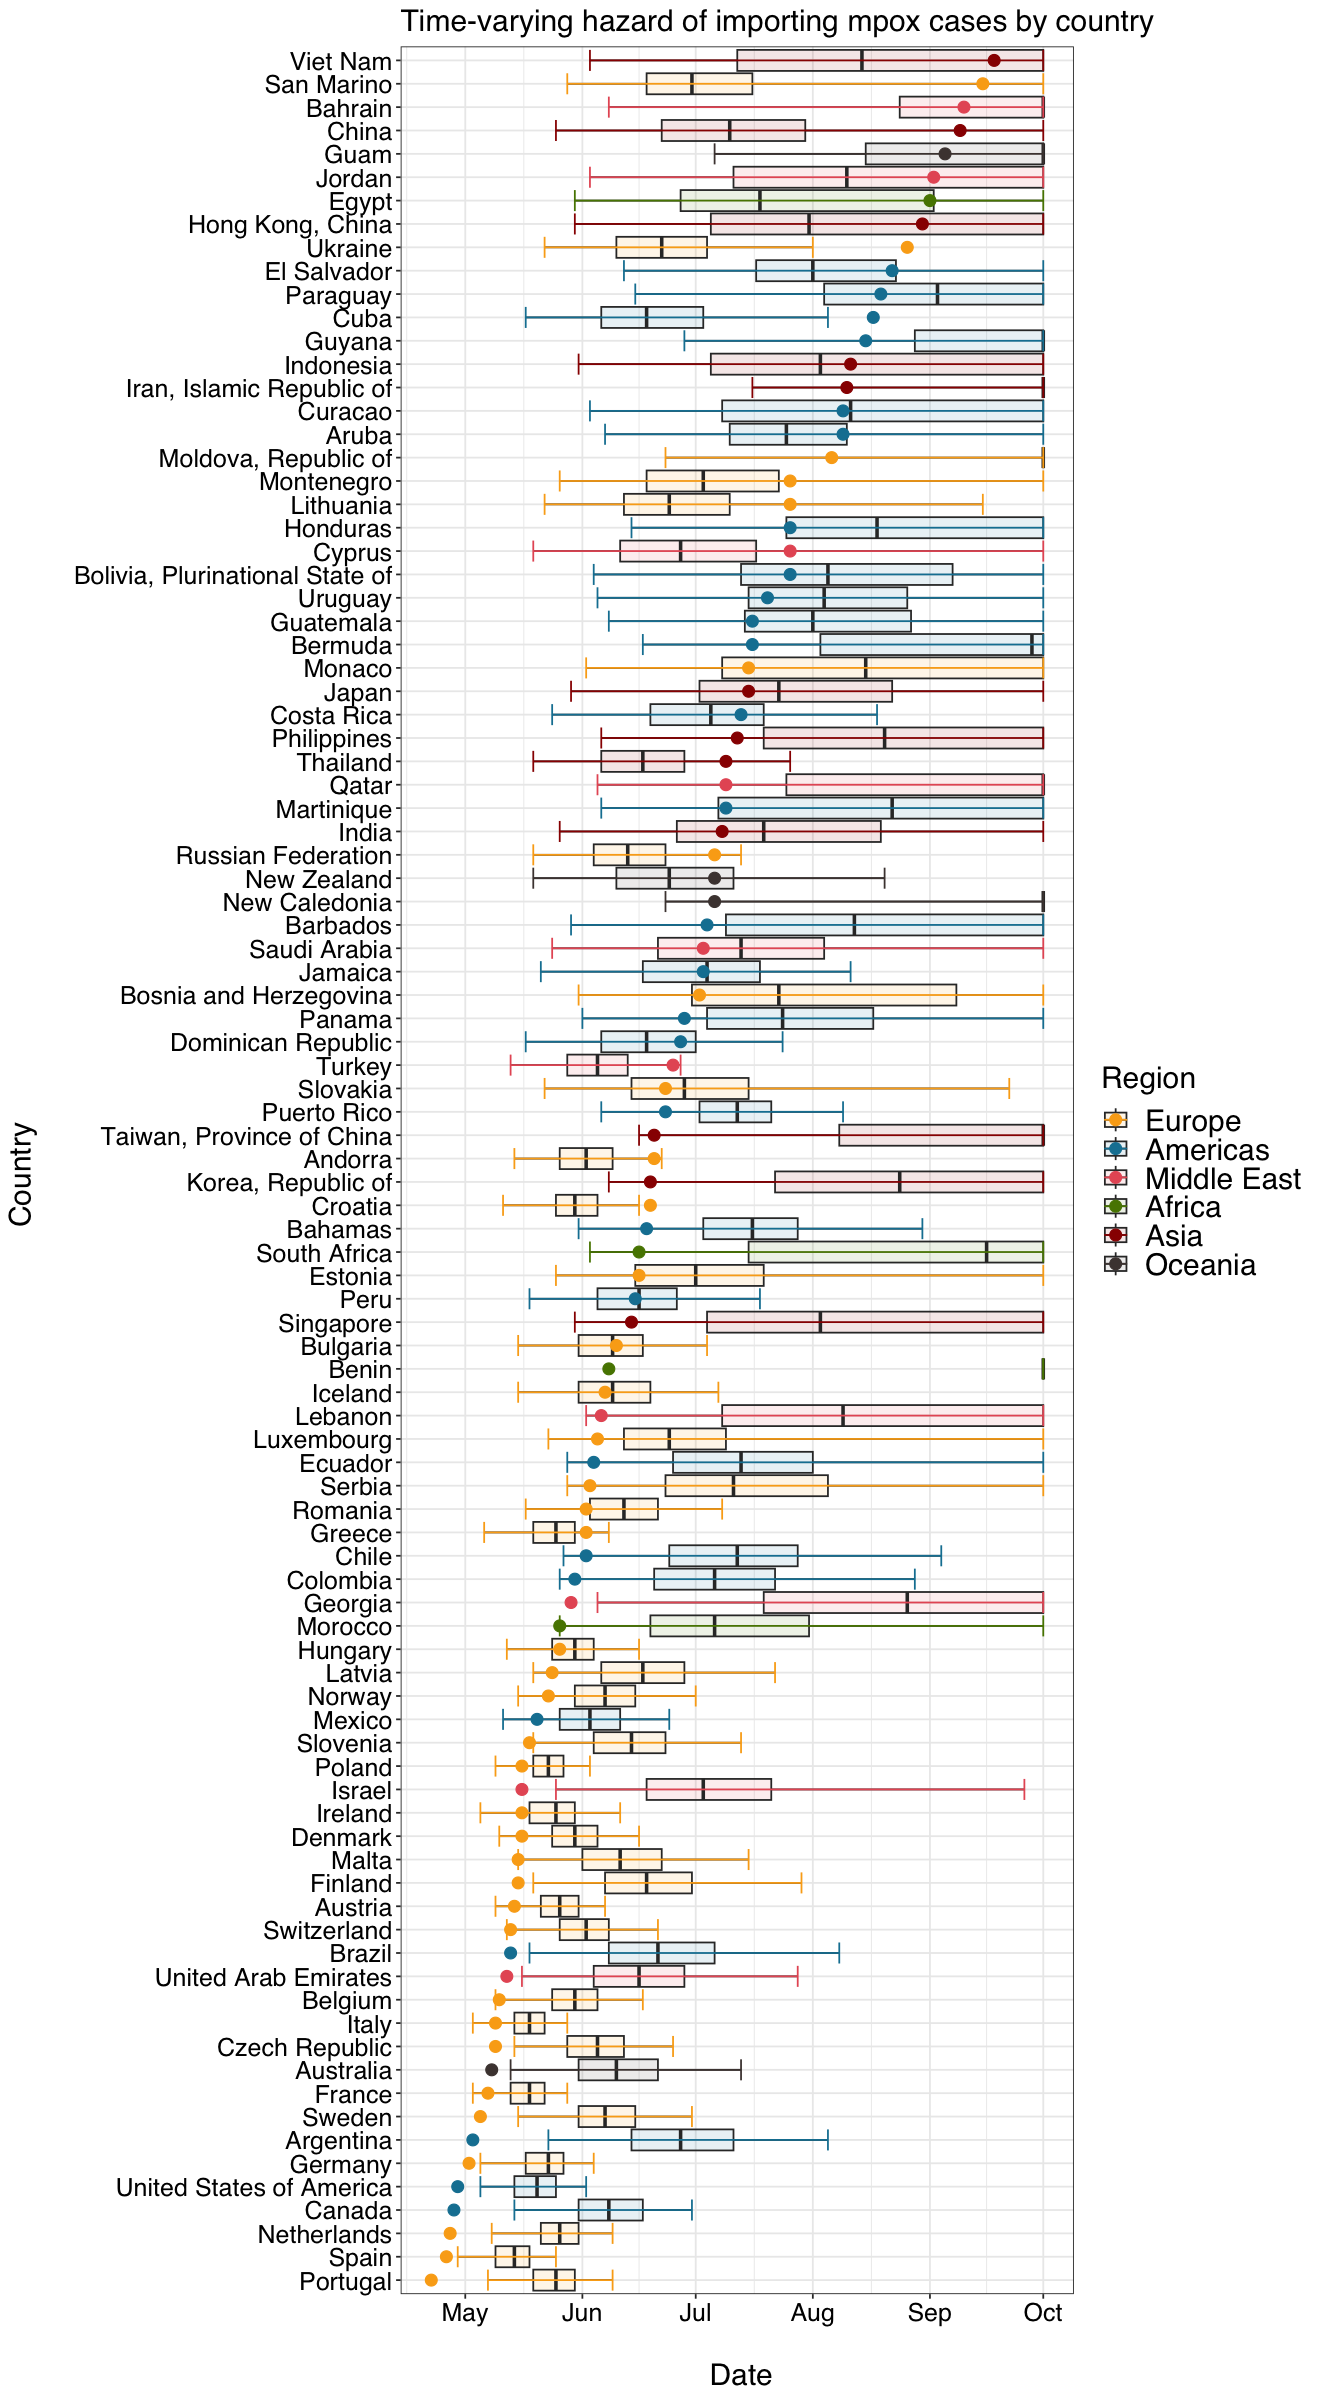

In [31]:
#### figure
rbind(quan_list0_fig, quan_list_fig) -> quan_list_all
Survf_region_fig %>% mutate(date_imp=date_imp_num+start_date-1) %>% 
dplyr::select(country, date_imp) %>% distinct() %>% arrange(date_imp) -> quan_imp_list0

df_input %>% dplyr::select(country, region, sub_region) %>% distinct() -> temp
merge(quan_imp_list0, temp, by=c("country")) %>%
mutate(group=case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"), 
                       TRUE~region)) -> quan_imp_list0

merge(quan_list_all, temp, by=c("country")) %>%
mutate(group=case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"), 
                       TRUE~region)) -> quan_list_all

options(repr.plot.width=11,repr.plot.height=20)
quan_list_all %>% arrange(date_imp_num) %>% 
filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                        "Congo","Congo, Democratic Republic of the","Ghana","United Kingdom"))) %>%
ggplot() +
geom_boxplot(aes(x = reorder(country,date_imp_num), 
                 ymin = q025, lower = q25, middle = q5, upper = q75, ymax = q975, fill=group), 
             stat = "identity", alpha=0.1) +
# scale_fill_manual("Region", values = c("#588300", "#1380A1", "#990000", "#FAAB18", "#E75B64FF", "#4C413FFF")) +
scale_fill_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
geom_errorbar(aes(x = reorder(country,date_imp_num), ymin = q025, ymax = q975, color=group)) +
geom_point(data=quan_imp_list0 %>%
           filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                                   "Congo","Congo, Democratic Republic of the","Ghana","United Kingdom"))), 
           aes(x=reorder(country,date_imp), y=date_imp, color=group), size=3) +
# scale_color_manual("Region", values = c("#588300", "#1380A1", "#990000", "#FAAB18", "#E75B64FF", "#4C413FFF")) +
scale_color_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
labs(x="Country \n", y="\n Date") +
ggtitle("Time-varying hazard of importing mpox cases by country") + 
  theme(text = element_text(size=15, family="sans",color="black"),
        axis.title = element_text(size=18, family="sans",color="black"),
        axis.text = element_text(size=15, family="sans",color="black"),
#         panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 18),
        plot.title = element_text(size=18, family="sans",color="black")) +
scale_y_date(date_labels = "%b", breaks="1 month") +
coord_flip(xlim = NULL, ylim = NULL, expand = TRUE, clip = "on")

ggsave("../figures/final_figures/FigS2_conv.png", width = 11, height = 20, dpi=600)


#### coverage within the 50% and 95% range
quan_list_all %>% 
filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                        "Congo","Congo, Democratic Republic of the","Ghana","United Kingdom"))) %>%
mutate(date_imp=date_imp_num+start_date-1) %>% 
mutate(count_50=case_when(date_imp <= q25 & date_imp >= q75 ~ 1, TRUE ~ 0),
       count_95=case_when(date_imp <= q025 & date_imp >= q975 ~ 1, TRUE ~ 0)) -> counts

sum(counts$count_50)/nrow(counts); sum(counts$count_50)
sum(counts$count_95)/nrow(counts); sum(counts$count_95)

In [32]:
df_input %>% filter(date >= start_date) %>% arrange(date, country) -> df_input_COI
df_input_COI %>% mutate(h_i=case_when(region == c("Europe") ~ F_i*exp(est_region$par)[1],
                                      region == c("Africa") ~ F_i*exp(est_region$par)[2],
                                      region == c("Americas") ~ F_i*exp(est_region$par)[3],
                                      region == c("Asia") ~ F_i*exp(est_region$par)[4],
                                      sub_region %in% c("Central Asia", "Western Asia") ~ F_i*exp(est_region$par)[5],
                                      region == c("Oceania") ~ F_i*exp(est_region$par)[6])) -> df_input_final
write.csv(df_input_final, "result.csv")

In [33]:
#### time-varying FOI
df_input %>% filter(date >= start_date) %>% arrange(date, country) -> df_input_COI
df_input_COI %>% mutate(h_i=case_when(region == c("Europe") ~ F_i*exp(est_region$par)[1],
                                      region == c("Africa") ~ F_i*exp(est_region$par)[2],
                                      region == c("Americas") ~ F_i*exp(est_region$par)[3],
                                      region == c("Asia") ~ F_i*exp(est_region$par)[4],
                                      sub_region %in% c("Central Asia", "Western Asia") ~ F_i*exp(est_region$par)[5],
                                      region == c("Oceania") ~ F_i*exp(est_region$par)[6]),
                        group=case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"),
                                        TRUE ~ region)) -> df_input_final
write.csv(df_input_final, "result.csv")

raw_global_FoI_data <- read.csv("result.csv")
raw_global_FoI_data$date <- as.Date(raw_global_FoI_data$date)
raw_global_FoI_data$date_import <- as.Date(raw_global_FoI_data$date_import)

global_FoI_data <- raw_global_FoI_data %>% filter(censor==0)
global_FoI_noimport_data <- raw_global_FoI_data %>% filter(censor==1)

vis_data <- global_FoI_data %>%
filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                        "Congo","Congo, Democratic Republic of the","Ghana","Palestine, State of", 
                        "United Kingdom")))

vis_data2 <- global_FoI_noimport_data %>%
filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                        "Congo","Congo, Democratic Republic of the","Ghana","Palestine, State of", 
                        "United Kingdom")))

In [34]:
#### Time-varying FoI figure for countries with mpox importations
limit_set <- c(min(raw_global_FoI_data$h_i), max(raw_global_FoI_data$h_i))
colort_set <- c("white","red","purple","darkorchid4","black")
label_set = c("0.5", "1.5", "2.5")
break_set = c(0.5, 1.5, 2.5)

options(repr.plot.width=11,repr.plot.height=20)
vis_data %>% arrange(date_import) %>%
ggplot() +
  geom_raster(aes(x=reorder(country, date_import), y=date, fill=h_i), alpha=1) +
#   scale_fill_gradient(low="white", high="red", name="Force of infection") +
#   scale_fill_gradient2(low="white", mid="red", high="black", space = "Lab", name="Force of infection") +
#   viridis::scale_fill_viridis(option="rocket", direction=-1, name="Force of infection") +
  scale_fill_gradientn(name="Force of infection", 
                       limits=limit_set,labels=label_set, breaks=break_set, colours = colort_set) +
  geom_point(aes(x=reorder(country, date_import), y=date_import, color=group), size=3)+
  theme(text = element_text(size=15, family="sans",color="black"),
        axis.title = element_text(size=18, family="sans",color="black"),
        axis.text = element_text(size=15, family="sans",color="black"),
#         panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 18),
        plot.title = element_text(size=18, family="sans",color="black")) +
scale_color_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
labs(x="Country \n", y="\n Date") +
ggtitle("Countries with reported importation events") + 
scale_y_date(date_labels = "%b", breaks="1 month", expand=c(0,0)) +
coord_flip(xlim = NULL, ylim = NULL, expand = TRUE, clip = "on") -> FoI_model

In [35]:
#### Time-varying FoI figure for countries without any importation
# limit_set <- c(min(vis_data2$h_i), max(vis_data2$h_i))
# limit_set <- c(min(vis_data2$h_i), 0.1)
# colort_set <- c("white","red","purple","darkorchid4","black")
# label_set = c("0.01", "0.03", "0.05"); break_set = c(0.01, 0.03, 0.05)
# label_set = c("0.03", "0.06", "0.09"); break_set = c(0.03, 0.06, 0.09)

options(repr.plot.width=11,repr.plot.height=20)
vis_data2 %>% arrange(country) %>%
ggplot() +
  geom_raster(aes(x=reorder(country, desc(country)), y=date, fill=h_i), alpha=1) +
  scale_fill_gradientn(name="Force of infection", colours = c("white","red","purple","darkorchid4","black")) +
  scale_fill_gradientn(name="Force of infection", 
                       limits=limit_set,labels=label_set, breaks=break_set, colours = colort_set) +
  theme(text = element_text(size=15, family="sans",color="black"),
        axis.title = element_text(size=18, family="sans",color="black"),
        axis.text = element_text(size=15, family="sans",color="black"),
#         panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 18),
        plot.title = element_text(size=18, family="sans",color="black")) +
scale_color_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
labs(x="", y="\n Date") +
ggtitle("Countries without any reported importation events") + 
scale_y_date(date_labels = "%b", breaks="1 month", expand=c(0,0)) +
coord_flip(xlim = NULL, ylim = NULL, expand = TRUE, clip = "on") -> fig_noimp

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


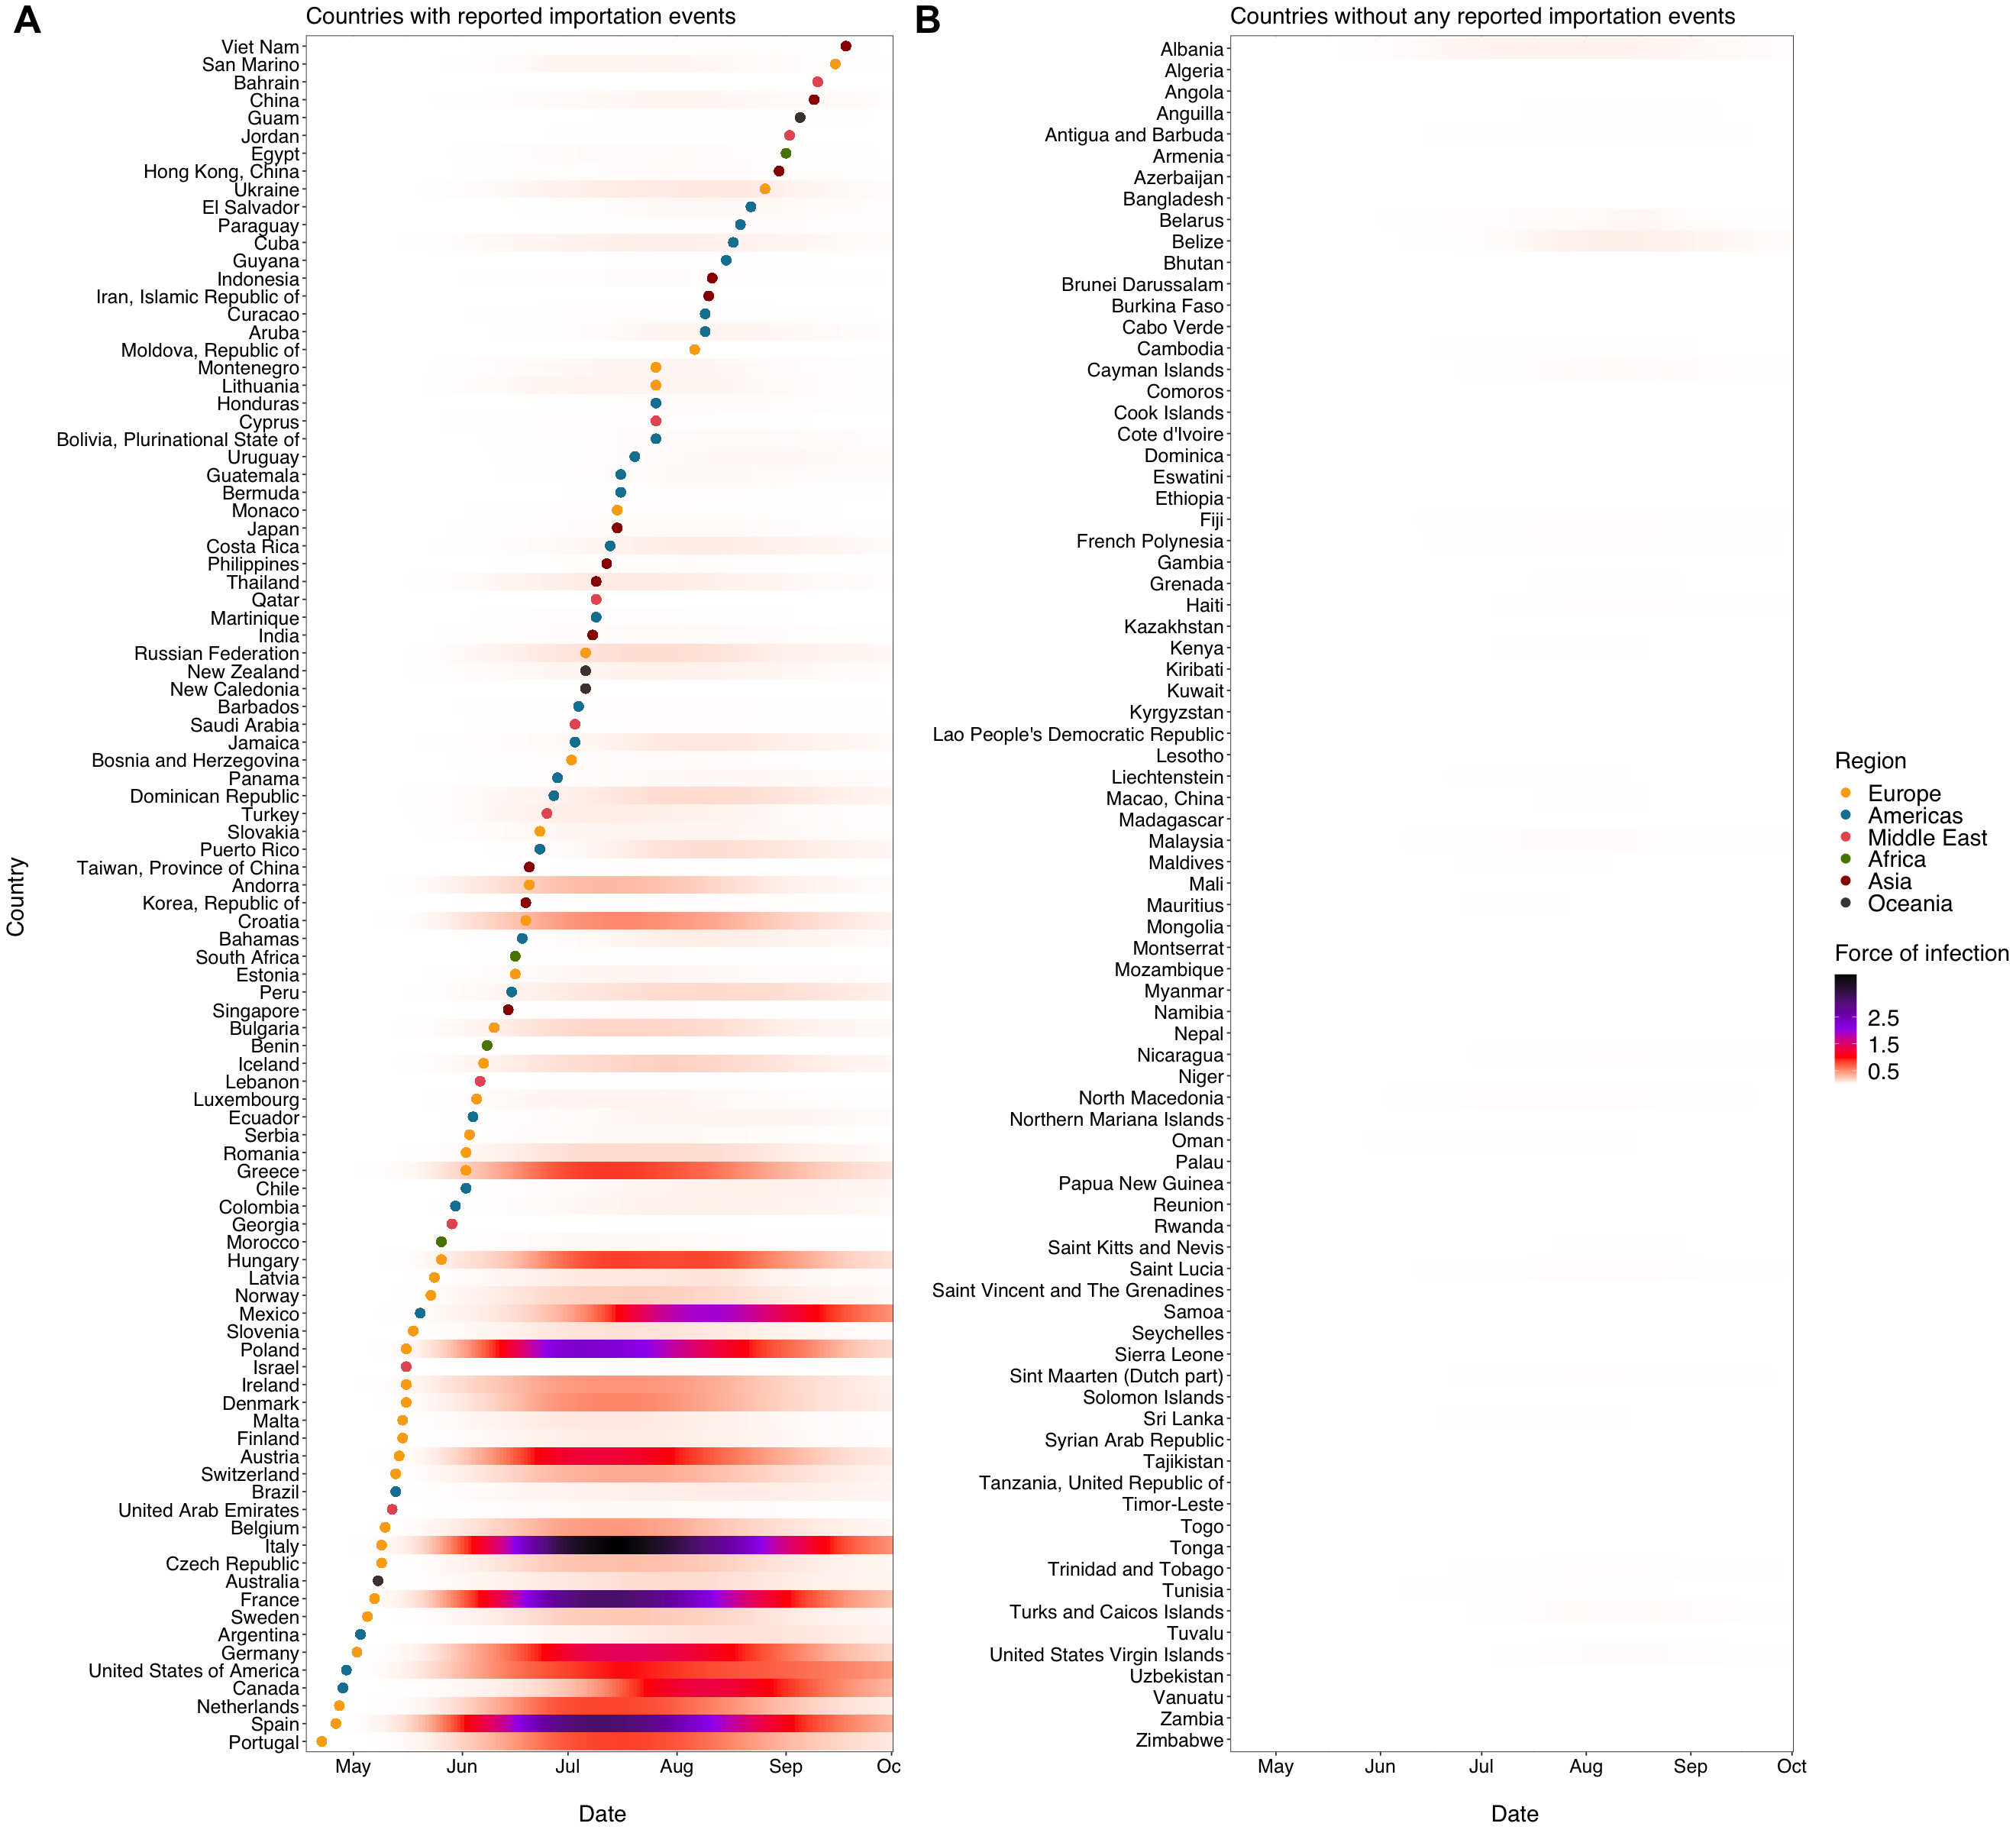

In [36]:
library(ggpubr)

options(repr.plot.width=22,repr.plot.height=20)
ggarrange(FoI_model, fig_noimp, ggplot() + theme_void(), nrow = 1, widths=c(1, 1, 0.03), 
          labels = c("A", "B",""), font.label = list(size = 30), vjust=1.2,
          common.legend = TRUE, legend="right")
ggsave("../figures/final_figures/Fig2_conv.png", width = 22, height = 20, dpi=600)

In [66]:
#### The model without the depletion effect
df_input_counter %>% filter(date >= start_date) %>% arrange(date, country) -> df_input_counter_COI
df_input_counter_COI %>%
mutate(h_i=case_when(region == c("Europe") ~ F_i*exp(est_region_counter$par[1]),
                     region == c("Africa") ~ F_i*exp(est_region_counter$par[2]),
                     region == c("Americas") ~ F_i*exp(est_region_counter$par[3]),
                     region == c("Asia") ~ F_i*exp(est_region_counter$par[4]),
                     sub_region %in% c("Central Asia", "Western Asia") ~ F_i*exp(est_region_counter$par[5]),
                     region == c("Oceania") ~ F_i*exp(est_region_counter$par[6])),
                     group=case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"),
                                     TRUE ~ region)) -> df_counter_final
write.csv(df_counter_final, "result_counter.csv")

raw_global_FoI_data_counter <- read.csv("result_counter.csv")
raw_global_FoI_data_counter$date <- as.Date(raw_global_FoI_data_counter$date)
raw_global_FoI_data_counter$date_import <- as.Date(raw_global_FoI_data_counter$date_import)

global_FoI_data <- raw_global_FoI_data_counter %>% filter(censor==0)
global_FoI_noimport_data <- raw_global_FoI_data_counter %>% filter(censor==1)

vis_data_counter <- global_FoI_data %>%
filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                        "Congo","Congo, Democratic Republic of the","Ghana","Palestine, State of", 
                        "United Kingdom")))

vis_data_counter2 <- global_FoI_noimport_data %>%
filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                        "Congo","Congo, Democratic Republic of the","Ghana","Palestine, State of", 
                        "United Kingdom")))

In [67]:
exp(est_region_counter$par[5])

[1] 0.008341069

In [68]:
2.425511e-09/9.643915e-07

[1] 0.002515069

In [73]:
df_input_counter %>% filter(date >= start_date) %>% arrange(date, country) -> df_input_counter_COI
df_input_counter_COI %>%
mutate(region=case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"),
                       TRUE ~ region)) %>%
mutate(h_i=case_when(region == c("Europe") ~ F_i*exp(est_region_counter$par[1]),
                     region == c("Africa") ~ F_i*exp(est_region_counter$par[2]),
                     region == c("Americas") ~ F_i*exp(est_region_counter$par[3]),
                     region == c("Asia") ~ F_i*exp(est_region_counter$par[4]),
                     region == c("Middle East") ~ F_i*exp(est_region_counter$par[5]),
                     region == c("Oceania") ~ F_i*exp(est_region_counter$par[6]))) %>% 
filter(region==c("Middle East"))

X,country,time,iso_code,region,sub_region,date,new_cases,total_cases,MA_new_cases,⋯,MSM_pop,pop2022,cum_icni_prop,Reff_i,G_i,censor,conv_G_i,F_i,date_imp,h_i
<int>,<chr>,<int>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<date>,<dbl>
1178,Armenia,2,ARM,Middle East,Western Asia,2022-04-18,0,0,0,⋯,22.70000,2780.469,0,0.0,0,1,0,9.643915e-07,2022-10-01,8.044056e-09
1850,Azerbaijan,2,AZE,Middle East,Western Asia,2022-04-18,0,0,0,⋯,23.90000,10358.074,0,0.0,0,1,0,3.842540e-06,2022-10-01,3.205089e-08
2186,Bahrain,2,BHR,Middle East,Western Asia,2022-04-18,0,0,0,⋯,15016.77660,1472.233,0,0.1,0,0,0,5.470408e-06,2022-09-10,4.562905e-08
7394,Cyprus,2,CYP,Middle East,Western Asia,2022-04-18,0,0,0,⋯,12765.17760,1251.488,0,0.1,0,0,0,1.025372e-04,2022-07-26,8.552699e-07
10082,Georgia,2,GEO,Middle East,Western Asia,2022-04-18,0,0,0,⋯,18500.00000,3744.385,0,0.1,0,0,0,3.027026e-06,2022-05-29,2.524863e-08
12770,Israel,2,ISR,Middle East,Western Asia,2022-04-18,0,0,0,⋯,92190.75180,9038.309,0,0.1,0,0,0,2.003014e-05,2022-05-16,1.670728e-07
13442,Jordan,2,JOR,Middle East,Western Asia,2022-04-18,0,0,0,⋯,115115.86380,11285.869,0,0.1,0,0,0,4.608196e-06,2022-09-02,3.843729e-08
13610,Kazakhstan,2,KAZ,Middle East,Central Asia,2022-04-18,0,0,0,⋯,62.00000,19397.998,0,0.0,0,1,0,1.784298e-06,2022-10-01,1.488295e-08
14282,Kuwait,2,KWT,Middle East,Western Asia,2022-04-18,0,0,0,⋯,43.54250,4268.873,0,0.0,0,1,0,5.614431e-06,2022-10-01,4.683036e-08


In [56]:
0.07762883*exp(est_region_counter$par)[5]
9.643915e-07*exp(est_region_counter$par)[5]

[1] 0.0006475074

[1] 8.044056e-09

`summarise()` has grouped output by 'group'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'group'. You can override using the `.groups`
argument.
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`summarise()` has grouped output by 'group'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'group'. You can override using the `.groups`
argument.


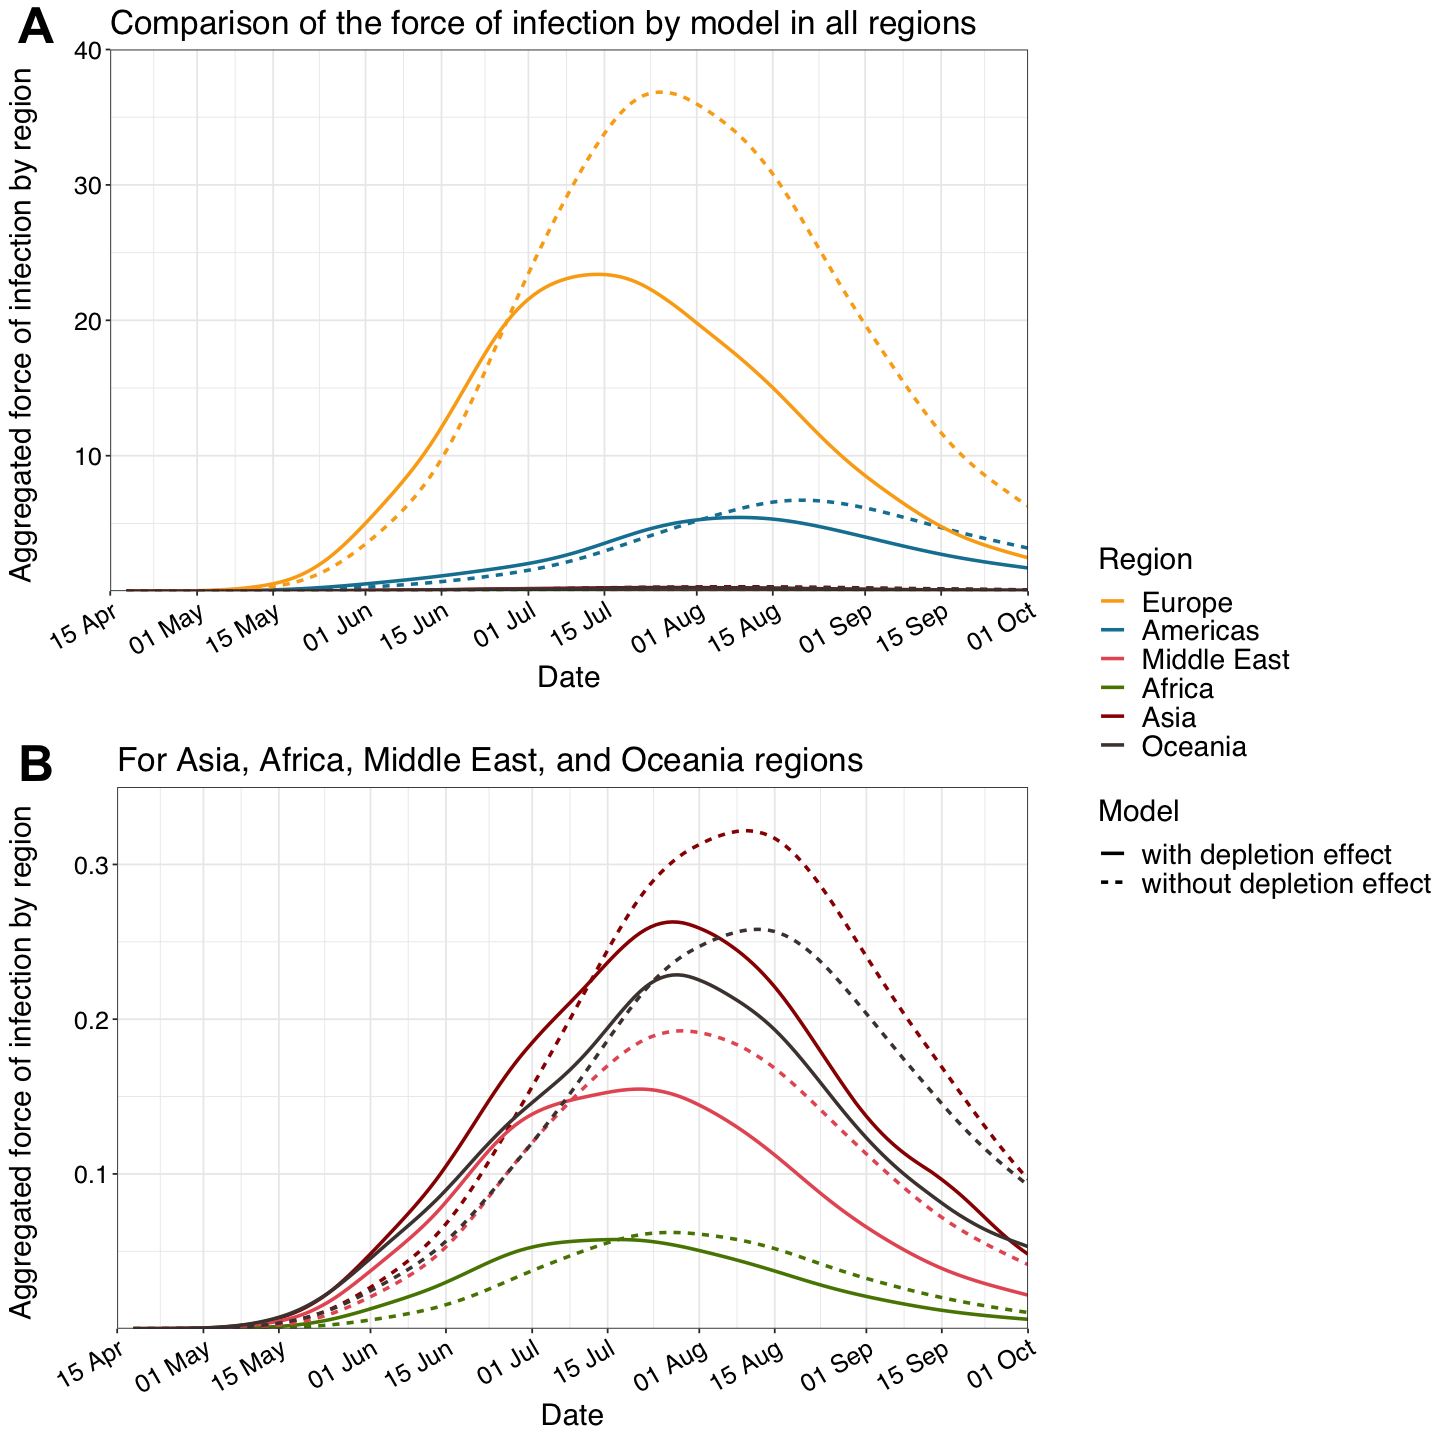

In [38]:
vis_data_counter %>% group_by(group, date) %>% summarize(h_i_region=sum(h_i)) %>% 
mutate(Model="without depletion effect") -> temp2
vis_data %>% group_by(group, date) %>% summarize(h_i_region=sum(h_i)) %>% 
mutate(Model="with depletion effect") -> temp1

rbind(temp2, temp1) -> figure_line

options(repr.plot.width=12,repr.plot.height=6)
ggplot(figure_line, aes(x = date, y=h_i_region, color = group, linetype = Model)) +
geom_line(size=1) +
scale_color_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
theme(text = element_text(size=15, family="sans",color="black"),
      plot.title = element_text(size=20, family="sans",color="black"),
      axis.title = element_text(size=18, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      legend.title = element_text(size = 18), legend.text = element_text(size = 17),
      axis.text.x=element_text(angle=30, hjust=1)) +
xlab("Date") +
ylab("Aggregated force of infection by region \n") +
ggtitle("Comparison of the force of infection by model in all regions") +
scale_x_date(date_labels = "%d %b", breaks=bimonthly,
             limits=c(as.Date("2022-04-15"), max(figure_line$date)), expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0), breaks=c(10, 20, 30, 40)) +
coord_cartesian(ylim = c(0,40)) -> fig1



vis_data_counter %>% group_by(group, date) %>% summarize(h_i_region=sum(h_i)) %>% 
mutate(Model="without depletion effect") %>% filter(!group %in% c("Europe", "Americas")) -> temp2
vis_data %>% group_by(group, date) %>% summarize(h_i_region=sum(h_i)) %>% 
mutate(Model="with depletion effect") %>% filter(!group %in% c("Europe", "Americas")) -> temp1

rbind(temp2, temp1) -> figure_line

options(repr.plot.width=12,repr.plot.height=6)
ggplot(figure_line, aes(x = date, y=h_i_region, color = group, linetype = Model)) +
geom_line(size=1) +
scale_color_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
theme(text = element_text(size=15, family="sans",color="black"),
      plot.title = element_text(size=20, family="sans",color="black"),
      axis.title = element_text(size=18, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      legend.title = element_text(size = 18), legend.text = element_text(size = 17),
      axis.text.x=element_text(angle=30, hjust=1)) +
xlab("Date") +
ylab("Aggregated force of infection by region \n") +
ggtitle("For Asia, Africa, Middle East, and Oceania regions") +
scale_x_date(date_labels = "%d %b", breaks=bimonthly,
             limits=c(as.Date("2022-04-15"), max(figure_line$date)), expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0), breaks=c(0.1, 0.2, 0.3)) +
coord_cartesian(ylim = c(0,0.35)) +
guides(color = guide_legend(order = 1), flinetypeill  = guide_legend(order = 2)) -> fig2

library(ggpubr)
options(repr.plot.width=12,repr.plot.height=12)

ggarrange(fig1, ggplot() + theme_void(), 
          ggplot() + theme_void(), ggplot() + theme_void(),
          fig2, ggplot() + theme_void(), ncol = 2, nrow = 3, 
          widths=c(1, 0.05, 1, 0.05, 1, 0.05), heights=c(1, 0.05, 1), 
          labels = c("A", "", "", "", "B", ""), font.label = list(size = 30), vjust=1.2,
          common.legend = TRUE, legend="right") -> fig3A
fig3A

ggsave("../figures/final_figures/FigS3_conv.png", width = 12, height = 12, dpi=600)

In [39]:
#### The model without the depletion effect
df_input_counter2 %>% filter(date >= start_date) %>% arrange(date, country) -> df_input_counter_COI
df_input_counter_COI %>% 
mutate(h_i=case_when(region == c("Europe") ~ F_i*exp(est_region$par)[1],
                     region == c("Africa") ~ F_i*exp(est_region$par)[2],
                     region == c("Americas") ~ F_i*exp(est_region$par)[3],
                     region == c("Asia") ~ F_i*exp(est_region$par)[4],
                     sub_region %in% c("Central Asia", "Western Asia") ~ F_i*exp(est_region$par)[5],
                     region == c("Oceania") ~ F_i*exp(est_region$par)[6]),
                     group=case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"),
                                     TRUE ~ region)) -> df_counter_final
write.csv(df_counter_final, "result_counter.csv")

raw_global_FoI_data_counter <- read.csv("result_counter.csv")
raw_global_FoI_data_counter$date <- as.Date(raw_global_FoI_data_counter$date)
raw_global_FoI_data_counter$date_import <- as.Date(raw_global_FoI_data_counter$date_import)

global_FoI_data <- raw_global_FoI_data_counter %>% filter(censor==0)
global_FoI_noimport_data <- raw_global_FoI_data_counter %>% filter(censor==1)

vis_data_counter <- global_FoI_data %>%
filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                        "Congo","Congo, Democratic Republic of the","Ghana","Palestine, State of", 
                        "United Kingdom")))

vis_data_counter2 <- global_FoI_noimport_data %>%
filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                        "Congo","Congo, Democratic Republic of the","Ghana","Palestine, State of", 
                        "United Kingdom")))

`summarise()` has grouped output by 'group'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'group'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'group'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'group'. You can override using the `.groups`
argument.


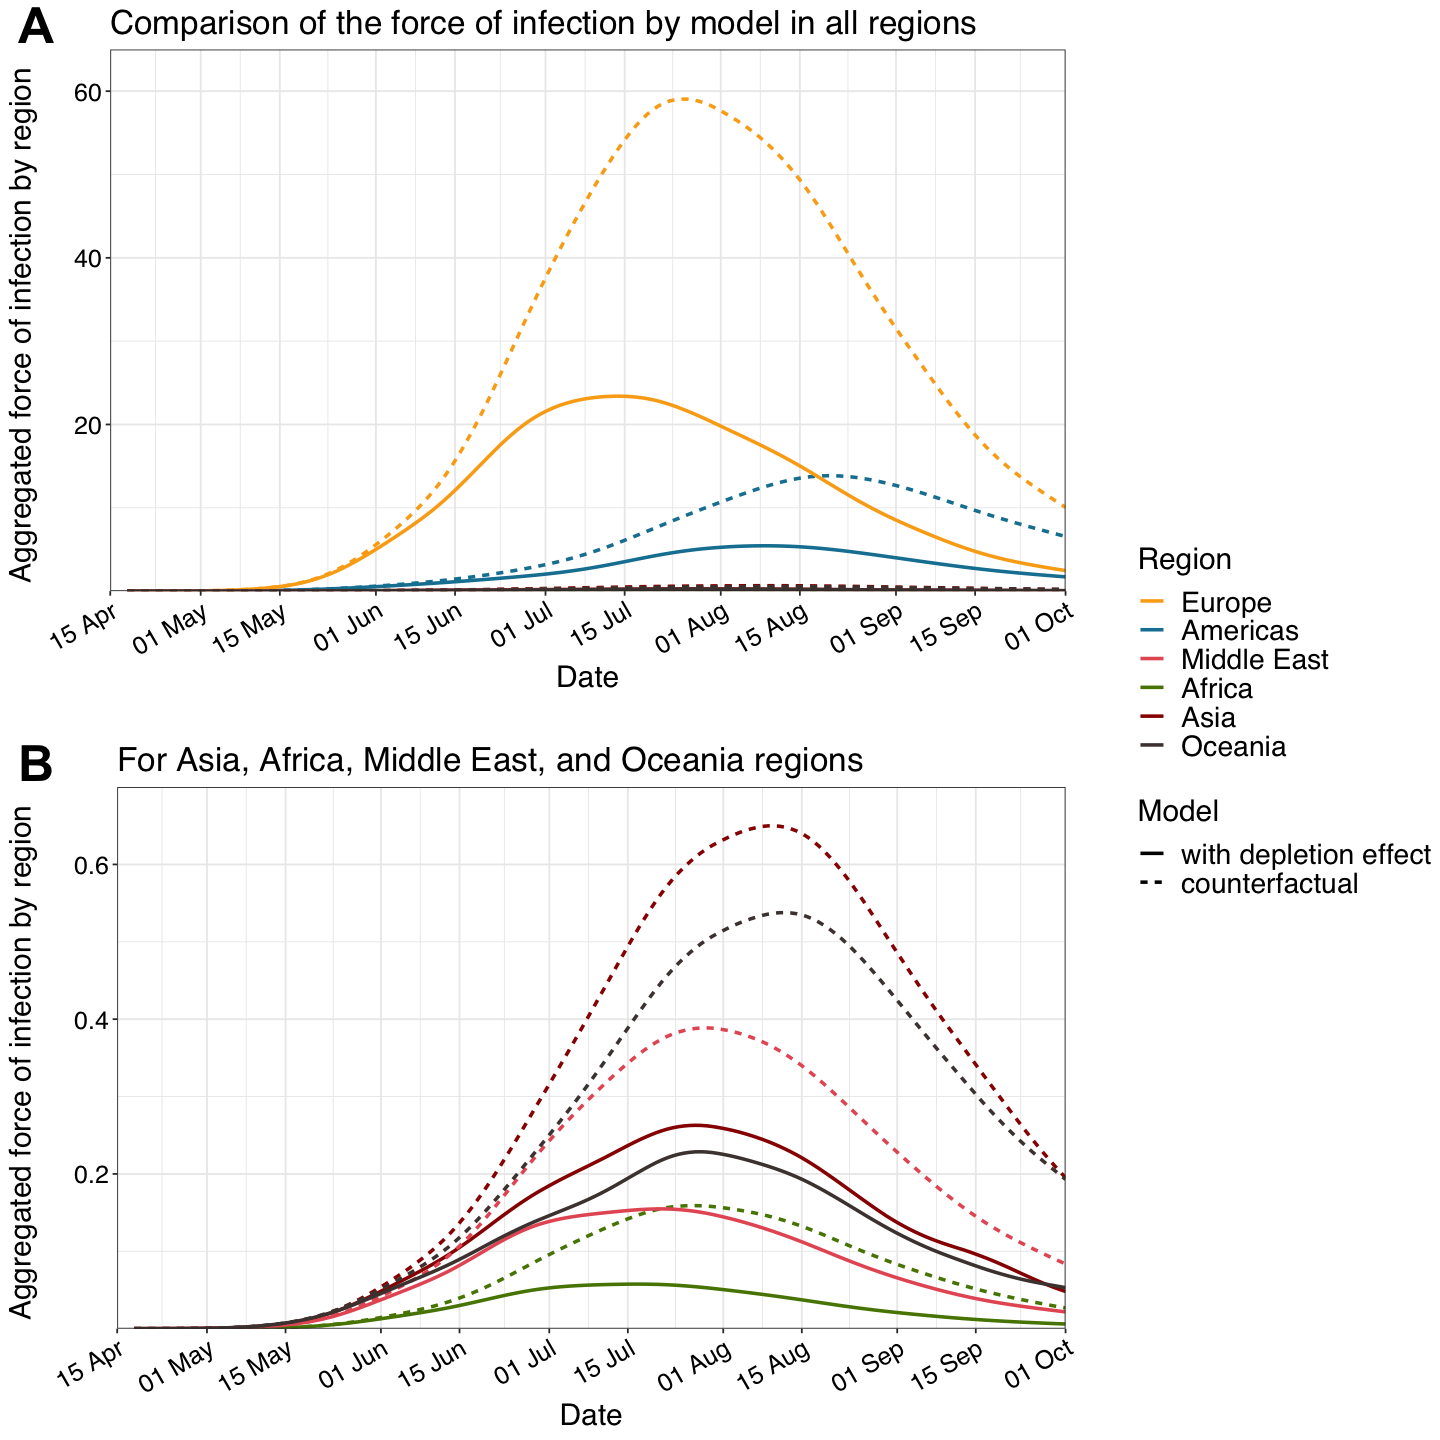

In [40]:
vis_data_counter %>% group_by(group, date) %>% summarize(h_i_region=sum(h_i)) %>% 
mutate(Model="counterfactual") -> temp2
vis_data %>% group_by(group, date) %>% summarize(h_i_region=sum(h_i)) %>% 
mutate(Model="with depletion effect") -> temp1

rbind(temp2, temp1) -> figure_line
figure_line$Model <- factor(figure_line$Model, levels=c("with depletion effect", "counterfactual"))

options(repr.plot.width=12,repr.plot.height=6)
ggplot(figure_line, aes(x = date, y=h_i_region, color = group, linetype = Model)) +
geom_line(size=1) +
scale_color_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
theme(text = element_text(size=15, family="sans",color="black"),
    plot.title = element_text(size=20, family="sans",color="black"),
    axis.title = element_text(size=18, family="sans",color="black"),
    axis.text = element_text(size=15, family="sans",color="black"),
    legend.title = element_text(size = 18), legend.text = element_text(size = 17),
    axis.text.x=element_text(angle=30, hjust=1)) +
xlab("Date") +
ylab("Aggregated force of infection by region \n") +
ggtitle("Comparison of the force of infection by model in all regions") +
scale_x_date(date_labels = "%d %b", breaks=bimonthly,
             limits=c(as.Date("2022-04-15"), max(figure_line$date)), expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0), breaks=c(20, 40, 60)) +
coord_cartesian(ylim = c(0,65)) -> fig1



vis_data_counter %>% group_by(group, date) %>% summarize(h_i_region=sum(h_i)) %>% 
mutate(Model="counterfactual") %>% filter(!group %in% c("Europe", "Americas")) -> temp2
vis_data %>% group_by(group, date) %>% summarize(h_i_region=sum(h_i)) %>% 
mutate(Model="with depletion effect") %>% filter(!group %in% c("Europe", "Americas")) -> temp1

rbind(temp2, temp1) -> figure_line
figure_line$Model <- factor(figure_line$Model, levels=c("with depletion effect", "counterfactual"))

options(repr.plot.width=12,repr.plot.height=6)
ggplot(figure_line, aes(x = date, y=h_i_region, color = group, linetype = Model)) +
geom_line(size=1) +
scale_color_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
theme(text = element_text(size=15, family="sans",color="black"),
    plot.title = element_text(size=20, family="sans",color="black"),
    axis.title = element_text(size=18, family="sans",color="black"),
    axis.text = element_text(size=15, family="sans",color="black"),
    legend.title = element_text(size = 18), legend.text = element_text(size = 17),
    axis.text.x=element_text(angle=30, hjust=1)) +
xlab("Date") +
ylab("Aggregated force of infection by region \n") +
ggtitle("For Asia, Africa, Middle East, and Oceania regions") +
scale_x_date(date_labels = "%d %b", breaks=bimonthly,
             limits=c(as.Date("2022-04-15"), max(figure_line$date)), expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0), breaks=c(0.2, 0.4, 0.6)) +
coord_cartesian(ylim = c(0,0.7)) +
guides(color = guide_legend(order = 1), flinetypeill  = guide_legend(order = 2)) -> fig2

options(repr.plot.width=12,repr.plot.height=12)

ggarrange(fig1, ggplot() + theme_void(), 
          ggplot() + theme_void(), ggplot() + theme_void(),
          fig2, ggplot() + theme_void(), ncol = 2, nrow = 3, 
          widths=c(1, 0.05, 1, 0.05, 1, 0.05), heights=c(1, 0.05, 1), 
          labels = c("A", "", "", "", "B", ""), font.label = list(size = 30), vjust=1.2,
          common.legend = TRUE, legend="right") -> fig3B

fig3B
ggsave("../figures/final_figures/Fig3_conv.png", width = 12, height = 12, dpi=600)

Warning message:
“ggrepel: 84 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 84 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


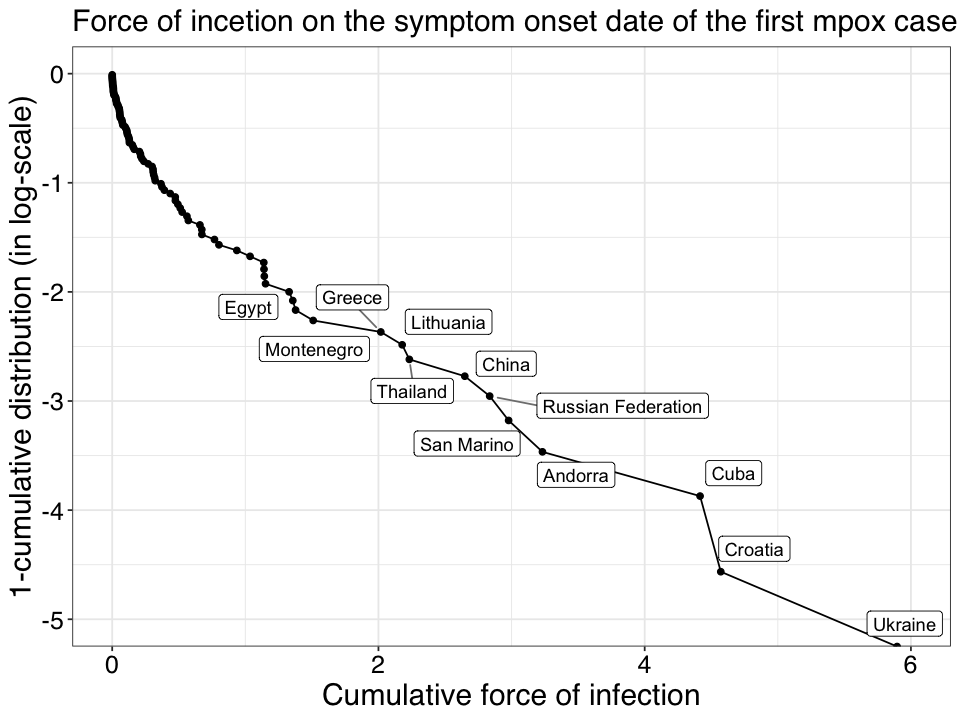

In [41]:
#### checking the linearity of log plot
library(ggrepel)
raw_global_FoI_data %>% filter(censor==0) %>% dplyr::select(country, group, date, date_import, h_i) %>%
arrange(country, date) %>% group_by(country) %>% mutate(cum_h_i=cumsum(h_i)) %>% 
filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                        "Congo","Congo, Democratic Republic of the","Ghana","Palestine, State of",
                        "United Kingdom"))) %>% ungroup() -> cum_global_FoI_data

## distribution of the CFOI at the date of importation
cum_global_FoI_data %>% mutate(diff=date_import-date) %>% filter(diff==0) -> temp
temp %>% group_by(cum_h_i) %>% summarise(n=n()) -> temp2
temp %>% group_by(cum_h_i) %>% summarise(n=n(), across()) %>% mutate(prop_n=n/sum(temp2$n)) %>% 
mutate(cum_prop_n=cumsum(prop_n), cum_prop_n2=log(1-cum_prop_n), log_x=log(cum_h_i)) -> temp_figure

options(repr.plot.width=8,repr.plot.height=6)
temp_figure %>%
ggplot(aes(x=cum_h_i, y=cum_prop_n2, label=country)) +
geom_point() +
geom_line() +
geom_label_repel(box.padding = 0.35, point.padding = 0.5, segment.color = 'grey50') +
  theme(text = element_text(size=15, family="sans",color="black"),
        axis.title = element_text(size=18, family="sans",color="black"),
        axis.text = element_text(size=15, family="sans",color="black"),
        plot.title = element_text(size=18, family="sans",color="black")) +
# scale_y_continuous(limits=c(-4.6, 0)) + 
# scale_x_continuous(limits=c(0, 6)) + 
scale_y_continuous(limits=c(-5, 0)) + 
scale_x_continuous(limits=c(0, 6)) + 
ggtitle("Force of incetion on the symptom onset date of the first mpox case") + 
labs(x="Cumulative force of infection", 
     y="1-cumulative distribution (in log-scale)") -> fig
fig

ggsave("../figures/final_figures/FigS1_conv.png", width = 8, height = 6, dpi=600)